In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

# Load and preprocess MNIST dataset

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28*28).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28*28).astype(np.float32) / 255.

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)

(60000, 784) float32
(10000, 784) float32


# Draw MNIST examples

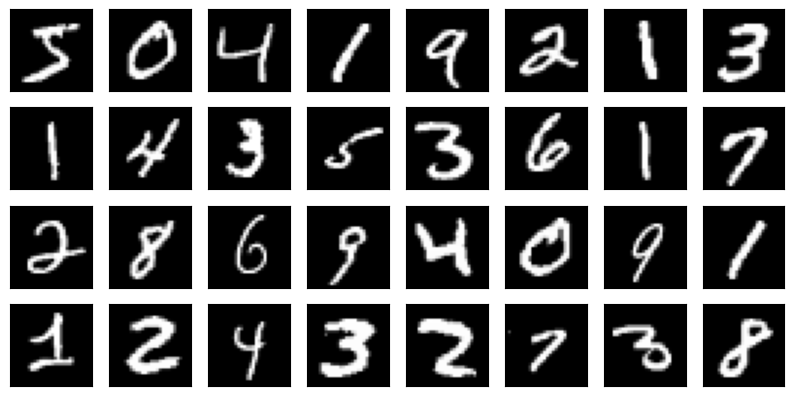

In [3]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
plot_digits(train_x[:32, ...])

# Create VAE parts: Encoder and Decoder

In [17]:
class Encoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(2, activation=None)
        self.fc3 = tf.keras.layers.Dense(2, activation=None)

    def call(self, inp):
        h = self.fc1(inp)
        z_mean = self.fc2(h)
        z_log_sigma = self.fc3(h)
        batch_size = inp.shape[0]
        rnd = tf.random.normal(tf.shape(z_mean))
        z = z_mean + tf.exp(z_log_sigma) * rnd
        return z_mean, z_log_sigma, z

class Decoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(784, activation='sigmoid')

    def call(self, inp):
        h = self.fc1(inp)
        out =- self.fc2(h)
        return out

    
encoder = Encoder()
decoder = Decoder()

# VAE infrrence and loss functions

In [18]:
def vae(inp):
    _, _, z = encoder.predict(inp)
    out = decodr.preict(z)
    return out

def vae_loss(inp, target):
    z_mean, z_log_sigma, z = encoder(inp)
    pred = decoder(z)
    
    mse_loss = tf.reduce_sum(tf.square(pred - target), axis=1)
    tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
    KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
    return tf.reduce_mean(mse_loss + KL_loss)

# Training parameters, dataset pipeline, optimize

In [19]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = .001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.legacy.RMSprop(LEARNING_RATE)

# VAE training

In [ ]:
for e in range(NUM_EPOCHS):
    for batch in train_ds:
        with tf.GradientTape() as tape:
            loss_value = vae_loss(batch, batch)
        train_vars = encoder.variables + decoder.variables
        grads = tape.gradient(loss_value, train_vars)
        optimizer.apply_gradients(zip(grads, train_vars))
    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))

[Epoch  0] Train Loss: 87.2708
[Epoch  1] Train Loss: 86.1204
[Epoch  2] Train Loss: 91.8307
[Epoch  3] Train Loss: 90.2847
[Epoch  4] Train Loss: 88.6436
[Epoch  5] Train Loss: 86.3302
[Epoch  6] Train Loss: 90.4963
[Epoch  7] Train Loss: 82.8635


# Decoder infrrence test: encoded inputs

In [ ]:
plot_digits(decoder.predict(text_x_enc))

# Decoder inference test: random imputs

In [ ]:
plot_digits(decoder.predict(np.random.rand(8, 4, 4, 8) * 5))

# Prepare noisy dataset (for Denoising AE)

In [ ]:
def add_noise(x):
    return np.clip(x + .5 + .5 * np.random.rand(*x.shape), 0, 1)

train_x_noise = add_noise(train_x)
test_x_noise = add_noise(test_x)

plot_digits(train_x_noise[:8])                   

# Denoising Autoencoder training

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

autoencoder.fit(train_x_noise, train_x,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(test_x_noise, test_x))

# DEnoiseing Autoencoder inference test

In [ ]:
text_x_pred = autoencoder.predict(test_x_noise[0:8])

plot_digits(test_x_noise[0:8])
plot_digits_x_pred